In [1]:
import tensorflow as tf
import numpy as np

In [2]:
HISTORY_TIMES = [3, 7, 15, 31, 47, 63, 95, 127]

In [3]:
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.001
batch_size = 12

# Network Parameters
num_input = 12 * len(HISTORY_TIMES) + 12       # dimension of one input at moment
num_hidden = 100     # num of lstms in first hidden layer
num_hidden2 = 100    # num of lstms in second hidden layer
#num_hidden3 = 150    # num of lstms in second hidden layer
num_output = 12      # output dimension

# tf graph input
X = tf.placeholder("float", [batch_size, None, num_input])

lstm = tf.contrib.rnn.MultiRNNCell([
    tf.contrib.rnn.LSTMCell(num_hidden, forget_bias=1.0),
    tf.contrib.rnn.LSTMCell(num_hidden2, forget_bias=1.0),
    #tf.contrib.rnn.BasicLSTMCell(num_hidden3, forget_bias=1.0)
])

lstm_outputs, _ = tf.nn.dynamic_rnn(lstm, X[:, :-1], dtype=tf.float32)

ans = tf.layers.dense(lstm_outputs, num_output, activation=None)

ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=ans, labels=X[:, 1:, :num_output])
loss_op = tf.reduce_mean(ce)

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
# optimizing
train_op = tf.contrib.layers.optimize_loss(
                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [4]:
# Start training
config = tf.ConfigProto(log_device_placement=True, device_count = {'GPU': 0})  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)

In [5]:
# Run the initializer
sess.run(init)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def drawNotes(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

In [7]:
songs = np.load("CM_dataset.npy")

In [8]:
def transform(song):
    ans = song[:, :12].copy()
    for i in range(12, 88):
        ans[:, i % 12] |= song[:, i]
    
    batch = []
    for n in range(12):
        batch.append(np.roll(ans, n, axis=1))
    batch = np.array(batch)
    
    wh = batch.copy()
    for t in HISTORY_TIMES:
        h = np.roll(batch, t, axis=1)
        h[:, :t] = 0
        wh = np.concatenate([wh, h], axis=2)        
    
    return wh

hsongs = [transform(song) for song in songs]

0.659336  mean for last:  0.659336


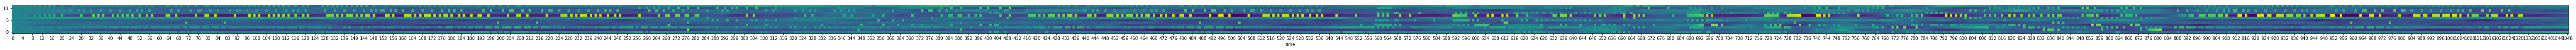

0.440092  mean for last:  0.355256


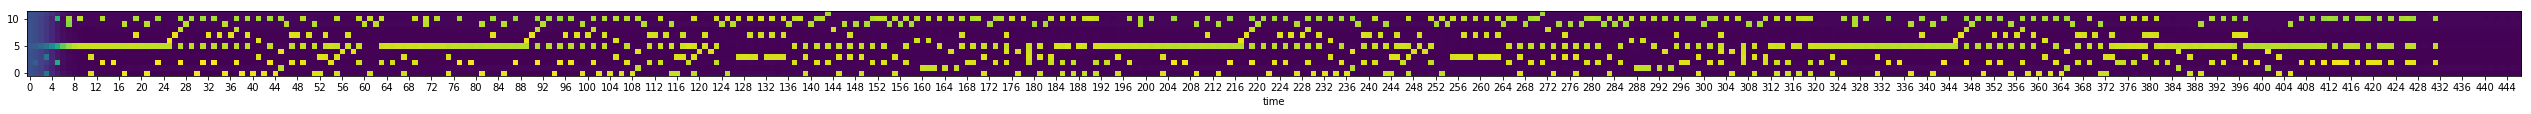

0.191816  mean for last:  0.308712


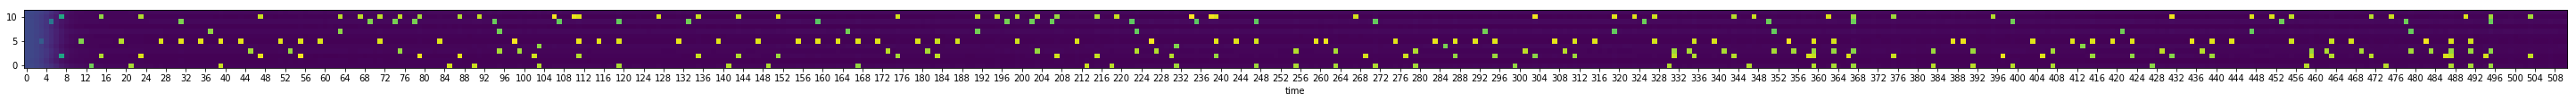

0.165519  mean for last:  0.319043


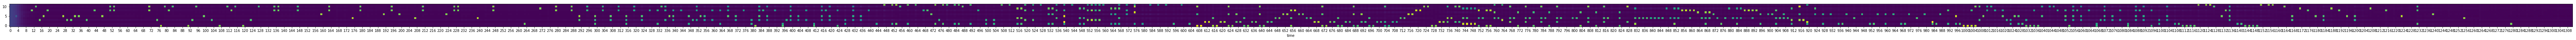

0.320651  mean for last:  0.283425


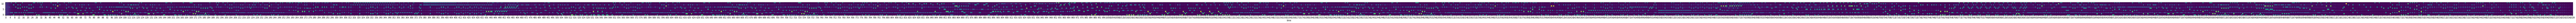

0.252913  mean for last:  0.254156


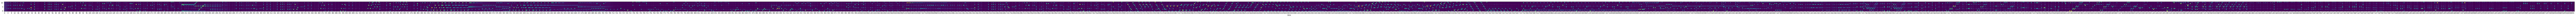

0.290473  mean for last:  0.259567


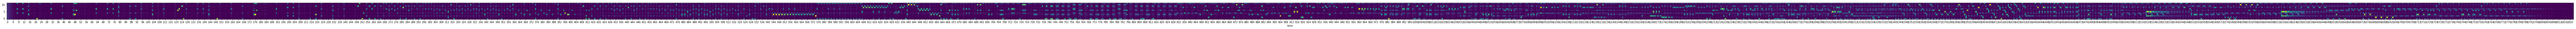

0.148302  mean for last:  0.252202


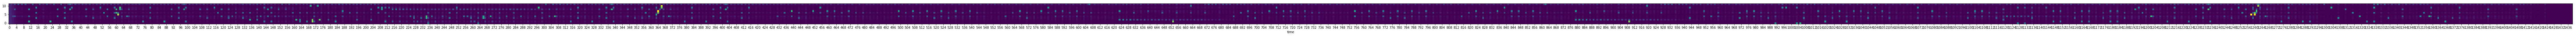

0.242508  mean for last:  0.252032


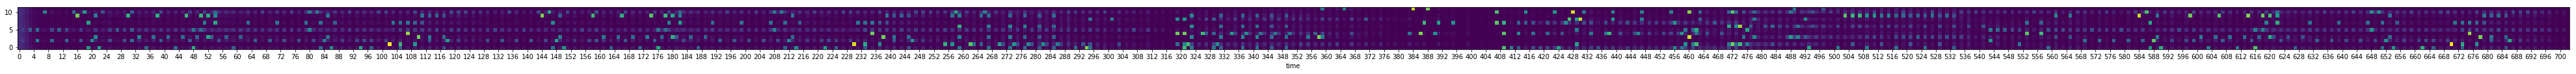

0.293373  mean for last:  0.246997


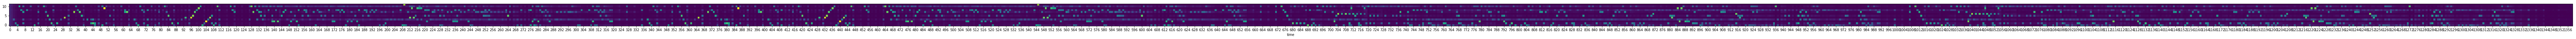

0.0852898  mean for last:  0.241498


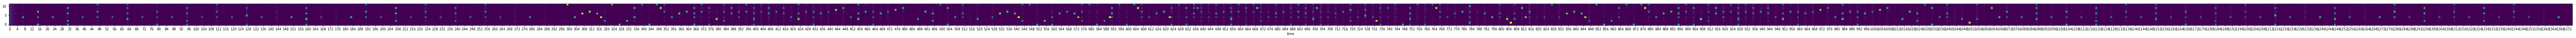

0.351017  mean for last:  0.233188


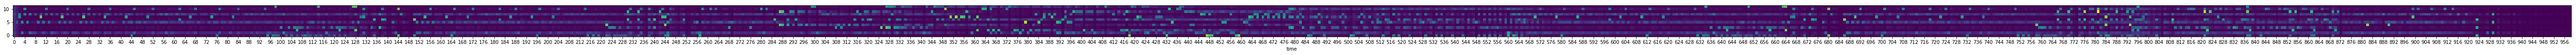

0.290128  mean for last:  0.241945


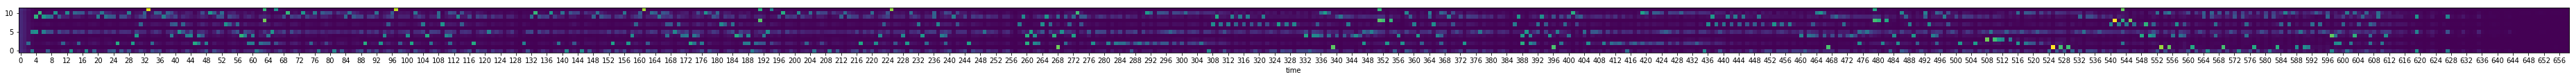

0.194705  mean for last:  0.237294


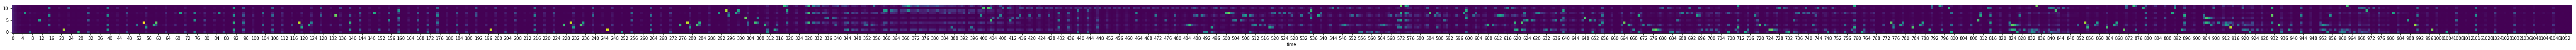

0.21329  mean for last:  0.236089


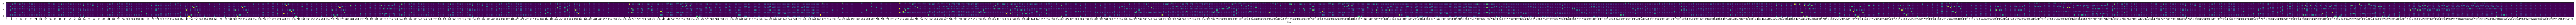

0.294347  mean for last:  0.2415


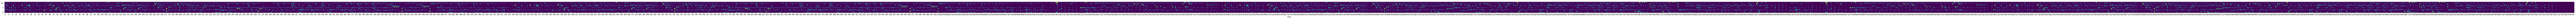

0.26446  mean for last:  0.243456


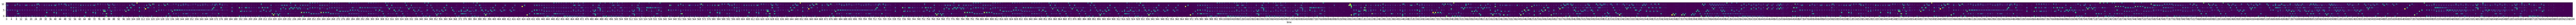

0.113599  mean for last:  0.228499


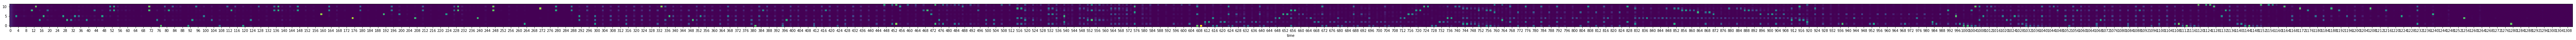

0.227589  mean for last:  0.251021


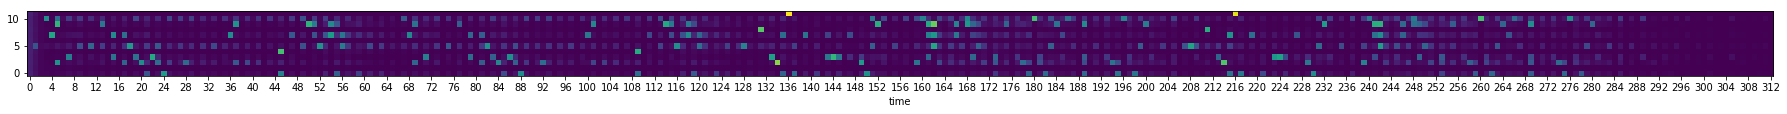

0.148828  mean for last:  0.236006


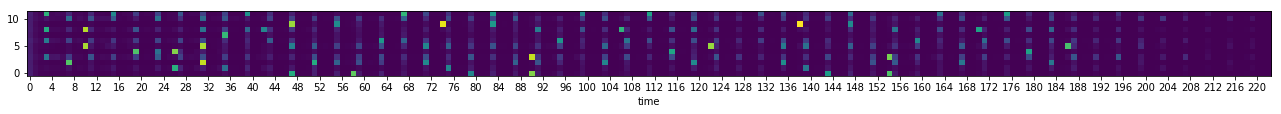

0.255704  mean for last:  0.239281


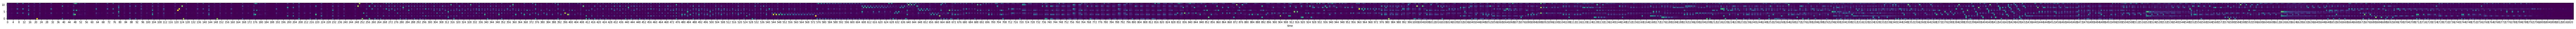

0.234922  mean for last:  0.239229


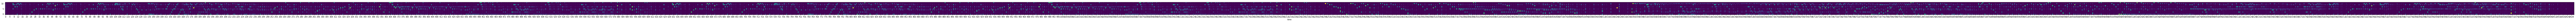

0.243875  mean for last:  0.233041


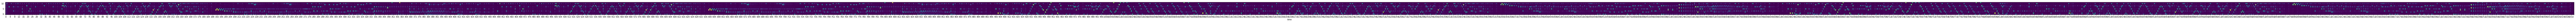

0.209128  mean for last:  0.230196


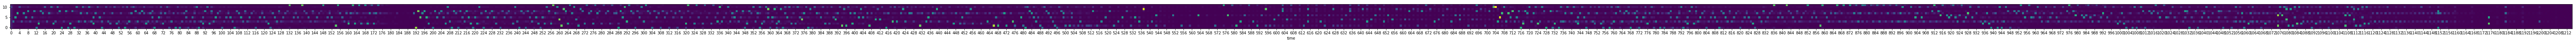

0.220862  mean for last:  0.234626


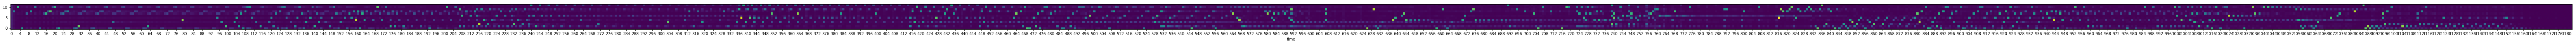

0.111421  mean for last:  0.233247


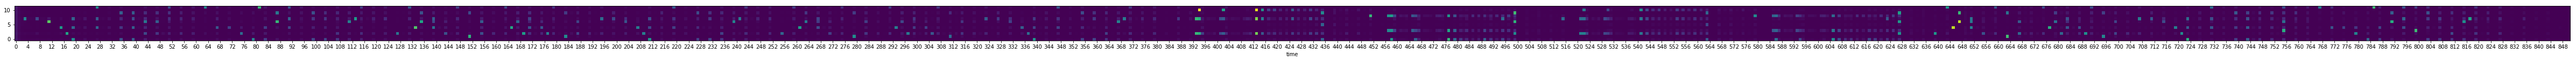

0.194043  mean for last:  0.246495


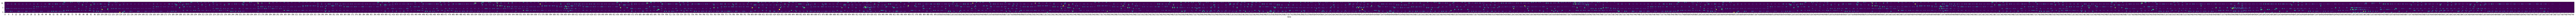

0.217619  mean for last:  0.247817


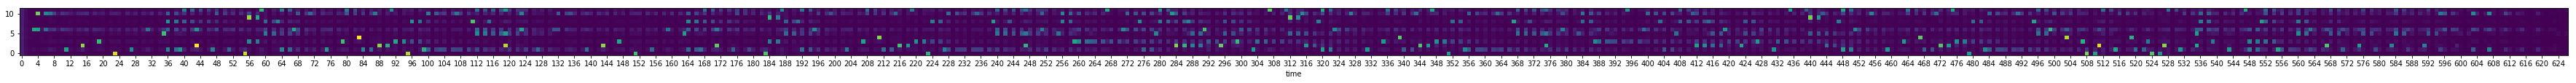

0.276936  mean for last:  0.23095


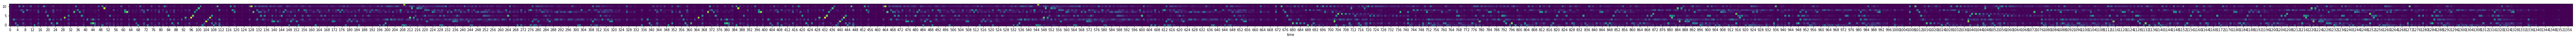

0.183158  mean for last:  0.223903


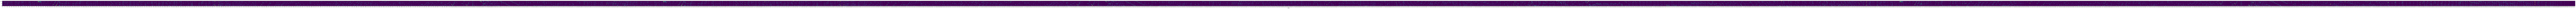

0.20683  mean for last:  0.227354


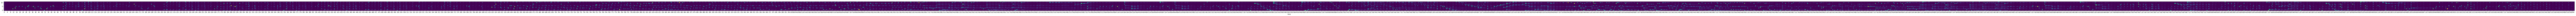

0.193449  mean for last:  0.223125


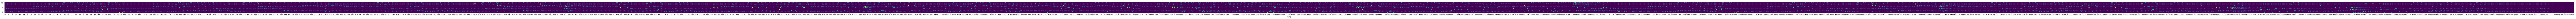

0.299373  mean for last:  0.228868


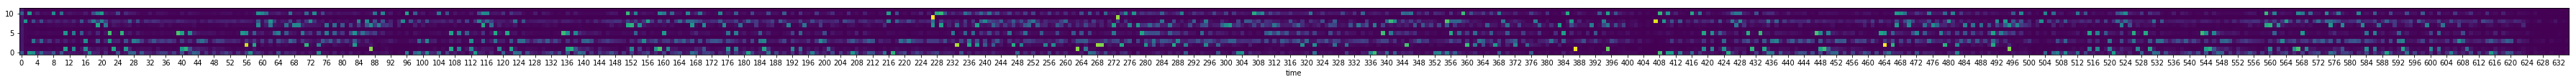

0.260156  mean for last:  0.229285


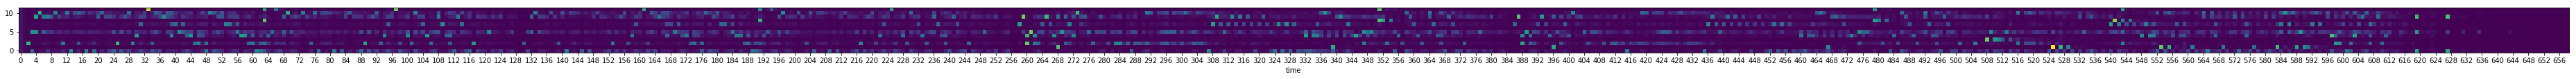

0.276375  mean for last:  0.221461


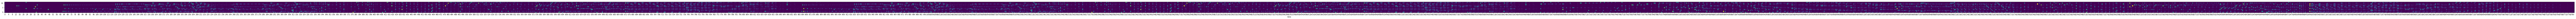

0.275787  mean for last:  0.223102


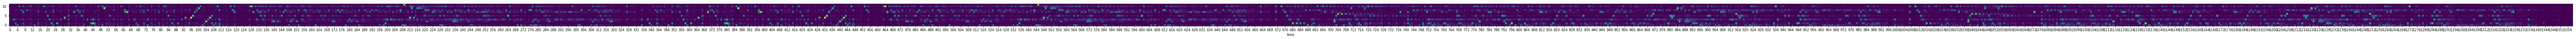

0.312056  mean for last:  0.24511


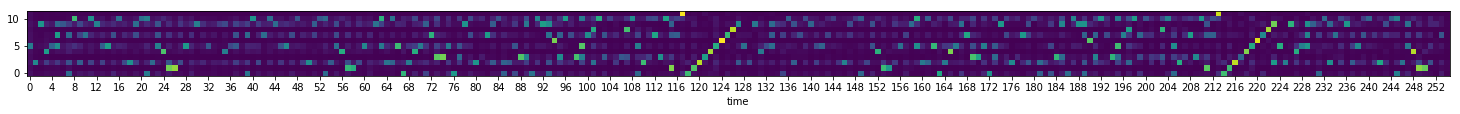

0.258344  mean for last:  0.242704


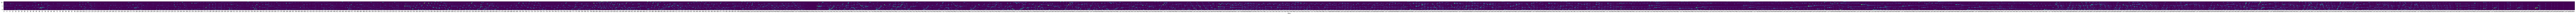

0.21388  mean for last:  0.235411


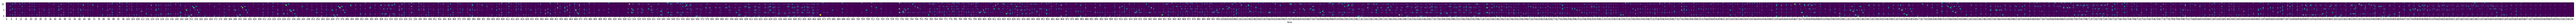

0.364056  mean for last:  0.228665


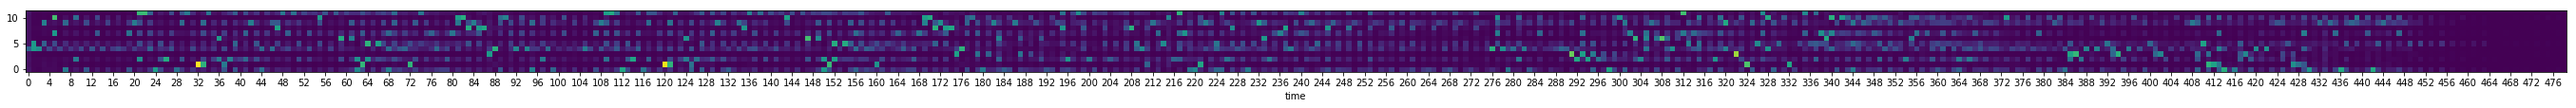

0.213613  mean for last:  0.221046


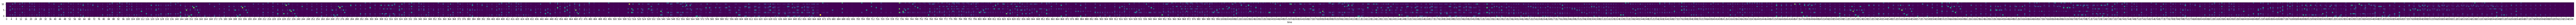

KeyboardInterrupt: 

In [9]:
training_steps = 10000
display_step = 50

losses = []
for step in range(training_steps + 1):
    # getting data
    batch_x = hsongs[np.random.randint(0, 100)]
    # Run optimization step
    sess.run(train_op, feed_dict={X: batch_x})
    
    L = sess.run(ce, feed_dict={X: batch_x})
    losses.append(L.mean())
    
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0])

print("Optimization Finished!")

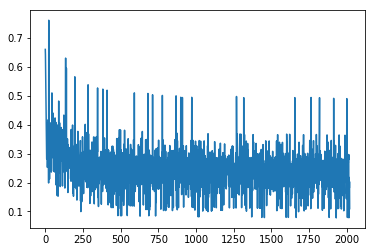

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

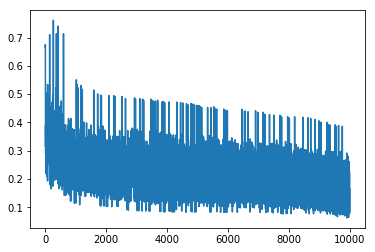

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

In [11]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()

# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, 88))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat / FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

In [12]:
probas = sess.run(tf.sigmoid(ans), feed_dict={X: hsongs[0]})

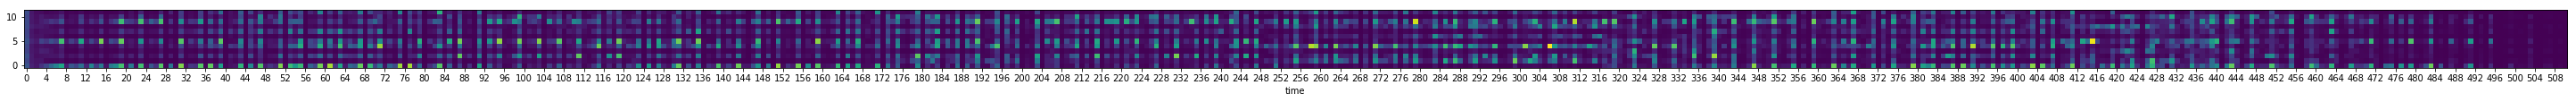

In [13]:
drawNotes(probas[0])

In [14]:
def transform(song):    
    batch = []
    for n in range(12):
        batch.append(np.roll(song, n, axis=1))
    batch = np.array(batch)
    
    wh = batch.copy()
    for t in HISTORY_TIMES:
        h = np.roll(batch, t, axis=1)
        h[:, :t] = 0
        wh = np.concatenate([wh, h], axis=2)        
    
    return wh

In [15]:
hsongs[79].shape

(12, 3488, 108)

In [16]:
gen = hsongs[79][0, :16, :12]

In [17]:
while len(gen) < 512:
    probas = sess.run(tf.sigmoid(ans), feed_dict={X: transform(gen)})

    res = np.random.uniform(0, 1, 12) < probas[0, -1]
    gen = np.vstack([gen, res])

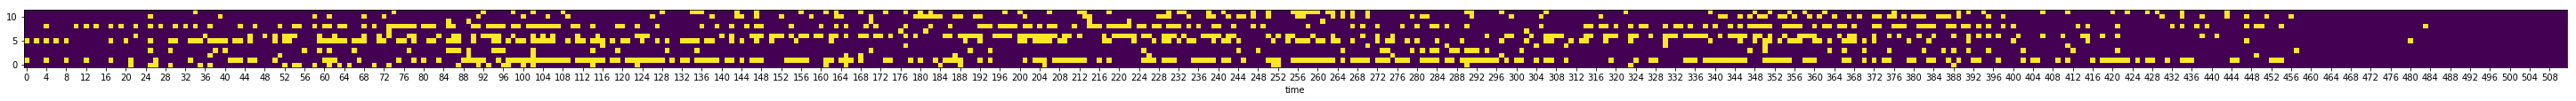

In [18]:
drawNotes(gen)

In [19]:
notes = np.zeros((gen.shape[0], 88))
notes[:, 39:51] = gen

In [20]:
ms = MySong(notes, finished=True)

In [21]:
ms.play()

KeyboardInterrupt: 

In [22]:
saver = tf.train.Saver()
saver.save(sess, "./tmp/100-100 LSTM 100 songs 12 notes with 8-history rolled ~2000 steps lr=0.001.ckpt")

'./tmp/100-100 LSTM 100 songs 12 notes with 8-history rolled ~2000 steps lr=0.001.ckpt'